[18-6-2020]

Note to self: I may create a Github repository for all codes that I have written for this project. [?]

[19-6-2020] 

Note to self: May make the code neater by trying to do something like: combining "gaus_noise_presence" and "subsampling_noise_presence" into "nature_of_noise", which can be tuned into "artificial_gaussian_noise" or "subsampling_noise".

Any other actions to do in this aspect of characterising the noise?

In [1]:
import numpy as np
import math
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import operator

# Highest Level SBPS algorithm

[16-6-2020]

Some of the steps that I have not implemented yet:
1. Suspicious step: gradient ascent after acceptance/rejection step
2. Introduction of auxiliary time


Moreover, I may need to add more outputs to SBPS for purposes such as diagnosing, etc.

[19-6-2020]

Catching an idea that I have:
Because your project is not just about “your invention of new SBPS algorithm” –- there are other technical details to learn such as all those experiments you need to run, I wonder whether I should just go with the current original SBPS algorithm that I invented. [?]

In [2]:
def SBPS(x0, v0, Time, lambda_ref, prob_dist, delta_t, k):
    
    # Need to ensure that euclidean norm of v0 equals 1.
    
    turn_pts = [x0]
    list_of_velo = [v0]
    striding_times = [0]
    dim = x0.size
    i = 1
    x = x0
    v = v0
    t = 0
    
    delta_U_tilde, G_tilde, c_t_squared, log_grad_list_0 = eval_G_tilde_plus_emp_var(x, v, prob_dist)
    next_array_of_obs = np.array([[0, G_tilde, c_t_squared]])    # time; G_tilde; variance
    
    
    while t < Time:
        
        tau_bounce, observed_grad, next_array_of_obs = bounce_time_local_linear_reg_paper_version(x, v, next_array_of_obs, 
                                                                                                  prob_dist, delta_t, k)
        beta = 1/lambda_ref
        tau_ref = np.random.exponential(scale = beta)
    
    
        tau = min(tau_bounce, tau_ref)
        x = x + tau*v
        t = t + tau
        
        
        if tau_ref < tau_bounce:
            unscaled_v = np.random.standard_normal(dim)
            v = unscaled_v / np.linalg.norm(unscaled_v)
        else:
            v = reflection(v, observed_grad)
            
        
        list_of_velo.append(v)
        turn_pts.append(x)
        striding_times.append(t)
        i = i+1


    return turn_pts, list_of_velo, striding_times     # [x_list, v_list, t_list]

       

Reflection of Velocity - Function

In [3]:
def reflection(v, observed_grad):
    
    return v - 2*(np.sum(observed_grad*v)/(np.sum(observed_grad*observed_grad)))*observed_grad


# Sampling Locations at arbitrary time

In [4]:

def x_v_t_arbitrary_times(turn_pts, list_of_velo, striding_times, intermediate_times):
    
    num_changes = len(turn_pts)
    num_required_times = len(intermediate_times)
    tiling_interm_times = np.transpose(np.tile(intermediate_times, (num_changes, 1)))
    testing_mat_1 = tiling_interm_times - np.tile(striding_times, (num_required_times, 1))
    testing_mat_2 = np.where(testing_mat_1 >= 0, 1, 0)
    indices_no_later_than = np.sum(testing_mat_2, axis = 1) - 1
        
    turn_pts_no_later = [turn_pts[i] for i in indices_no_later_than]
    velo_no_later = [list_of_velo[i] for i in indices_no_later_than]
    stride_time_no_later = [striding_times[i] for i in indices_no_later_than]
    
       
    interm_times = list(intermediate_times)
        
    list_of_coasting_times = list(map(operator.sub, interm_times, stride_time_no_later))
    distance_strided = list(map(operator.mul, list_of_coasting_times, velo_no_later))
    locations_at_required_times = list(map(operator.add, turn_pts_no_later, distance_strided))
        

    return locations_at_required_times, velo_no_later, interm_times


# Approximating Cox Process: Local Linear Regression Upper Bound

Another error discovered in Ari's algorithm: after a reflection of velocity, it seems that the empirical variance will change. Hence, I corrected it in this code. [?]

In [28]:

def bounce_time_local_linear_reg_paper_version(x, v, initialised_arr_of_obs, prob_dist, delta_t, k, 
                                               mu_0=0, sig_0=1, mu_1=0, sig_1=1):
    
    accepted = 0
    time_coasted = 0
    
    
    array_of_observations = initialised_arr_of_obs
    
    
    while accepted == 0:
        
        hat_beta_0, hat_beta_1, Sigma_cov_mat = Bayesian_Linear_Regression_doub_gaus(array_of_observations, 
                                                                                 sig_0, mu_0, sig_1, mu_1)
    
        start_time = array_of_observations[-1,0]
        extrapolated_var = array_of_observations[-1,2]
    
        proposed_time, upper_bound_intensity = adaptive_thinning_paper_version(start_time, hat_beta_0, hat_beta_1, 
                                                    Sigma_cov_mat, extrapolated_var, k, delta_t)
    
        time_coasted = proposed_time
    
        observed_grad, acc_rej_G, acc_reg_var, log_grad_list = eval_G_tilde_plus_emp_var(x + time_coasted*v, v, prob_dist)
    
        prob_of_acc = probability_of_acceptance(max(0, acc_rej_G), upper_bound_intensity)
    
        sampling_prob = np.random.uniform()
    
        if sampling_prob < prob_of_acc:
            accepted = 1
            
            if prob_dist.nature_of_noise == 'artificial_gaus':
                reinitialised_arr_of_obs = np.array([[0, -acc_rej_G, acc_reg_var]])
                
                
            if prob_dist.nature_of_noise == 'subsampling':
                
                reflected_v = reflection(v, observed_grad)
                reflected_dot_prods = log_grad_list.dot(reflected_v)
                reflected_var = (prob_dist.num_obs**2)*(1 - prob_dist.n/prob_dist.num_obs)*np.var(reflected_dot_prods)
                
                reinitialised_arr_of_obs = np.array([[0, -acc_rej_G, reflected_var]])
            
        else:
            new_obs = np.array([[time_coasted, acc_rej_G, acc_reg_var]])
            array_of_observations = np.concatenate((array_of_observations, new_obs), axis=0)
            
            

            
            
            
    # What I need to return (may not be exhaustive): tau_bounce, observed_gradient, 
    # the re-initialised list of observations [[0,-G(t),c_t]].
    
    return time_coasted, observed_grad, reinitialised_arr_of_obs

In the following function for calculating probability of acceptance, I adopt the rule of "returning 0.5 if both \tilde{G}(t) = 0 and lambda(t) = 0". I wonder whether it is okay for me to write into the report that this case rarely occurs and the value I chose to output does not affect significantly the simulation?

[# Key lies in: whether underflowing occurs frequently or rarely. [?]]

In [6]:

def probability_of_acceptance(real_intensity, proposal_intensity):  # [G(t)]_{+}; lambda(t)
    
    if proposal_intensity > 0:
        return min(1, real_intensity/proposal_intensity)
    
    elif proposal_intensity == 0 and real_intensity > 0:
        return 1
    
    elif proposal_intensity == 0 and real_intensity == 0:
        return 0.5


# Function for observation a noisy gradient and estimating the variance

Note to self: this function is applicable only when noise_presence is set to True!!

In [29]:

def eval_G_tilde_plus_emp_var(x, v, prob_dist):
    
    if prob_dist.nature_of_noise == 'artificial_gaus':
        
        delta_U_mean = prob_dist.ener_grad(x)
        gaus_noise_vec = np.random.multivariate_normal(np.zeros(x.size), np.identity(x.size)*prob_dist.exact_gaus_noise_var)
        
        delta_U_tilde = delta_U_mean + gaus_noise_vec
        # print('delta_U_tilde:', delta_U_tilde)
        # print('v: ', v)
        
        G_tilde = v.dot(delta_U_tilde)
        
        c_t_squared = (v.dot(v))*prob_dist.exact_gaus_noise_var
        
        log_grad_list = ['N/A']
        
        
    if prob_dist.nature_of_noise == 'subsampling':
        
        delta_U_tilde, log_grad_list = prob_dist.ener_grad(x, list_sampling = True)
        dot_prod_list = log_grad_list.dot(v)
        
        G_tilde = v.dot(delta_U_tilde)
        
        c_t_squared = (prob_dist.num_obs**2)*(1 - prob_dist.n/prob_dist.num_obs)*np.var(dot_prod_list)
        
        
    return delta_U_tilde, G_tilde, c_t_squared, log_grad_list

# Function for Bayesian Linear Regression

N(sig_0, mu_0), N(sig_1, mu_1) are the priors I used. 

Each column of array_of_observations is [Time, G_tilde, variance].

Side-note: my calculations of E[beta_0], E[beta_1], E[beta_1^2], E[beta_1*beta_2], E[beta_2^2] shows that none of them involves the normalisation constant p(G_1, ..., G_m). This makes me feel that if I use a Uniform distribution for beta_0, then these 5 expectations still have closed form. [?]

In [9]:

def Bayesian_Linear_Regression_doub_gaus(array_of_observations, sig_0, mu_0, sig_1, mu_1):
    
    # print(array_of_observations)
    
    list_of_times = array_of_observations[:,0]
    list_of_G = array_of_observations[:,1]
    list_of_variances = array_of_observations[:,2]
    
    S_1 = np.sum(1/list_of_variances)/2
    S_2 = np.sum((1/list_of_variances)*(list_of_times))/2
    S_3 = np.sum((1/list_of_variances)*(list_of_G))/2
    
    S_4 = np.sum((1/list_of_variances)*(list_of_times)*(list_of_G))/2
    S_5 = np.sum((1/list_of_variances)*(list_of_times)*(list_of_times))/2
    S_6 = np.sum((1/list_of_variances)*(list_of_G)*(list_of_G))/2
    
    
    D_00 = -2*S_1 - 1/(sig_0**2)
    D_01 = -2*S_2
    D_02 = mu_0/(sig_0**2) + 2*S_3
    
    D_10 = -2*S_2
    D_11 = -2*S_5 - 1/(sig_1**2)
    D_12 = mu_1/(sig_1**2) + 2*S_4
    
    
    if D_01 == 0:
        
        expect_beta0 = -D_02/D_00
        expect_beta1 = -D_12/D_11
        expect_beta0_squared = (D_02/D_00)**2 - 1/D_00
        expect_beta1_squared = (D_12/D_11)**2 - 1/D_11
        expect_beta0_beta1 = (D_02*D_12)/(D_00*D_11)
    
    
    
    else:
        expect_beta0 = (D_01*D_12 - D_02*D_11)/(D_00*D_11 - D_01*D_10)
        expect_beta1 = (D_10*D_02 - D_12*D_00)/(D_00*D_11 - D_01*D_10)
        expect_beta0_squared = ((D_01*D_12 - D_02*D_11)/(D_00*D_11 - D_01*D_10))**2 + D_11/(D_01*D_10 - D_00*D_11)
        expect_beta1_squared = ((D_10*D_02 - D_12*D_00)/(D_00*D_11 - D_01*D_10))**2 + D_00/(D_01*D_10 - D_00*D_11)
        expect_beta0_beta1 = expect_beta0*expect_beta1 + D_10/(D_00*D_11 - D_01*D_10)
    
    
    hat_beta_0 = expect_beta0
    hat_beta_1 = expect_beta1
    
    Var_0 = expect_beta0_squared - (expect_beta0)**2
    Var_1 = expect_beta1_squared - (expect_beta1)**2
    Cov_01 = expect_beta0_beta1 - (expect_beta0)*(expect_beta1)
    
    Sigma_cov_mat = np.array([[Var_0, Cov_01], [Cov_01, Var_1]])
    

    
    # need to calculate E[beta_0], E[beta_1], E[beta_1^2], E[beta_1*beta_2], E[beta_2^2]
    
    return hat_beta_0, hat_beta_1, Sigma_cov_mat



Later, I will also revisit the issue of flat prior (going through the Bayesian Lasso paper, or clarify with Ari Pakman), and then write another function for Bayesian linear regression using flat prior.

In [ ]:

def Bayesian_Linear_Regression_flat_prior(array_of_observations, sig_0, mu_0, sig_1, mu_1):
    
    

# (The heart of controversies) Construct an Upper-Bound Intensity and Sample from it

Ari Pakman's version

In [72]:

def adaptive_thinning_paper_version(start_time, hat_beta_0, hat_beta_1, Sigma, extrapolated_var, k, delta_t):
    
    rho = lambda t: np.array([1,t]).dot(Sigma.dot(np.array([1,t]))) + extrapolated_var
    gamma = lambda t: hat_beta_1*t + hat_beta_0 + k*np.sqrt(rho(t))
    lambda_intensity = lambda t: max(0, gamma(t))
    
    
    V = np.random.uniform()*(-1)+1
    
    total_intensity = -math.log(V)
    num_piecewise_linear_travelled = 0
    t = start_time
    cumulative_intensity = 0
    
    num_loops = 0
    
    
    while cumulative_intensity < total_intensity:
        
        num_piecewise_linear_travelled = num_piecewise_linear_travelled + 1
        small_t = t
        large_t = t + delta_t
        
        increment = delta_t*(lambda_intensity(small_t) + lambda_intensity(large_t))/2
        cumulative_intensity = cumulative_intensity + increment
        
        t = t + delta_t
        num_loops = num_loops + 1
        
        if num_loops % 100 == 0:
            print('number of loops executed:', num_loops)
        
    remainder = total_intensity - (cumulative_intensity - increment)
    slope = (lambda_intensity(large_t) - lambda_intensity(small_t))/(delta_t)
    
    quad_soln = quadratic_equation(slope, 2*lambda_intensity(small_t), -2*remainder)
    
    
    if len(quad_soln[1]) == 1:
        proposed_time = small_t + (quad_soln[1])[0]
    elif len(quad_soln[1]) == 2:
        list_soln = [x for x in quad_soln[1] if x > 0 and x <= delta_t]
        proposed_time = small_t + list_soln[0]
    
    
    return proposed_time, lambda_intensity(proposed_time)

In [71]:
1 % 2 ==0

False

My version

In [ ]:

def adaptive_thinning_original_version(hat_beta_0, hat_beta_1, extrapolated_var, Sigma, k, delta_t):
    
    

A small function for solving quadratic equation ax^2 + bx +c = 0:

In [11]:

def quadratic_equation(a,b,c):
    
    if a==0 and b==0 and c==0:
        return ['a = b = c = 0','nannannan']
    
    elif a==0 and b==0 and (not c==0):
        return ['a = b = 0 but not c = 0', 'nannannan']
    
    elif a==0 and (not b==0):
        return ['proper linear equation', [-c/b]]
    
    elif (not a == 0) and (b**2 - 4*a*c < 0):
        return ['complex roots', 'nannannan']
    
    elif (not a == 0) and (b**2 - 4*a*c == 0):
        return ['repeated real root', [-b/(2*a)]]
    
    elif (not a == 0) and (b**2 - 4*a*c > 0):
        return ['distinct real roots', [(-b - math.sqrt(b**2 - 4*a*c))/(2*a), (-b + math.sqrt(b**2 - 4*a*c))/(2*a)]]

# In the following distributions, there are 2 types of noises: artificial gaussian noise and subsampling noise.

# Multivariate Gaussian (from my BPS toy codes)

Me: don't know how to add noise for energy function, but feels that this will not be used.

Notice: note that this noisy version of multivariate gaussian is probably too simple --- the noise variable added to the energy gradient anywhere has the same probability distribution. More complicated examples may have to be created.

In [30]:

class Gaussian:
    
    def __init__(self, mean, cov_mat, noise_presence, exact_gaus_noise_var, nature_of_noise = 'artificial_gaus'):
        
        self.mean = mean
        self.cov_mat = cov_mat
        self.dim = mean.size
        
        
        self.noise_presence = noise_presence
        self.exact_gaus_noise_var = exact_gaus_noise_var
        self.nature_of_noise = 'artificial_gaus'
    
    
    def energy(self, x): # constant coeff is discarded

        return 0.5*((x - self.mean).dot(np.linalg.inv(self.cov_mat)).dot(x - self.mean)) 
        
        
        
        
    def ener_grad(self, x):

        return (np.linalg.inv(self.cov_mat)).dot(x - self.mean)
           

# Probability Distribution: Noisy Access to Gradient

Large Dataset (Observations). Subsampling (without replacement) is performed to calculate gradient.

Me: so do I have exact access to the energy function?

Bernoulli Likelihood and N(0_d, I_d) used.

In [31]:


class Logistic_Regression_Bern_likelihood:
    
    
    def __init__(self, obs_input, obs_output, noise_presence, subsampling_num,
                 nature_of_noise = 'subsampling'):   # obs_input: [N,d]; obs_output: [N]; subsampling_num: n

        self.num_obs = obs_input.shape[0]
        self.obs_dim = obs_input.shape[1]
        self.obs_input = obs_input
        self.obs_output = obs_output
        
        self.n = subsampling_num
        self.noise_presence = noise_presence
        self.nature_of_noise = nature_of_noise
        
        self.prior_dist = Gaussian(mean = np.zeros(obs_input.shape[1]), cov_mat = np.identity(obs_input.shape[1]), 
                                   noise_presence = False, exact_gaus_noise_var = 0.01, nature_of_noise = 'artificial_gaus')
        
        
        

        
        
    
    
    
    def energy(self, w, var_calc):  # w: [d]
        
        if self.noise_presence == True:
            subsamples_index = np.random.choice(self.num_obs, self.n, replace=False)
            subsamples_input = self.obs_input[subsamples_index]
            subsamples_output = self.obs_output[subsamples_index]
        
        if self.noise_presence == False:
            subsamples_input = self.obs_input
            subsamples_output = self.obs_output
        
        
        interm_1 = (subsamples_input).dot(w)
        interm_11 = np.log(1 / (1 + np.exp(-interm_1)))
        interm_12 = np.log(1 - (1/(1 + np.exp(-interm_1))))
        
        indiv_likeli_ener = subsamples_output*(interm_11) + (1 - subsamples_output)*(interm_12)
        
        if self.subsampling_noise_presence == True:
            return self.prior_dist.energy(w) - (self.num_obs/self.n)*np.sum(indiv_likeli_ener)
        
        if self.subsampling_noise_presence == False:
            return self.prior_dist.energy(w) - np.sum(indiv_likeli_ener)
        
        
    
    
    
    
    
    
    def ener_grad(self, w, list_sampling): # x: np.array [d]
        
        if self.noise_presence == True:
            subsamples_index = np.random.choice(self.num_obs, self.n, replace=False)
            subsamples_input = self.obs_input[subsamples_index]
            subsamples_output = self.obs_output[subsamples_index]

            
        if self.noise_presence == False:
            subsamples_input = self.obs_input
            subsamples_output = self.obs_output
        
        
        lin_trans = (subsamples_input).dot(w)
        logistic_lin_trans = subsamples_output - 1/(1 + np.exp(-lin_trans))
        sum_to_R = logistic_lin_trans.dot(subsamples_input)
        
        sampled_grads = np.transpose(np.tile(logistic_lin_trans,(self.obs_dim, 1)))*subsamples_input
        # if noise_presence = False, then sampled_grads is the full N-by-d array of gradient the log-likelihood
        
        
        
        
        
        
        
        if self.noise_presence == True and list_sampling == True:
            return self.prior_dist.ener_grad(w) - (self.num_obs/self.n)*sum_to_R, sampled_grads
        
        if self.noise_presence == True and list_sampling == False:
            return self.prior_dist.ener_grad(w) - (self.num_obs/self.n)*sum_to_R
        
        if self.subsampling_noise_presence == False:
            return self.prior_dist.ener_grad(w) - sum_to_R
            
        
        


# One more toy distribution

Me: perhaps can do another (common and/or well-understood?) multivariate distribution?

# Debugging my codes by running them

# Try all these with Gaussian distribution

In [50]:
mean = np.zeros(2)
cov_mat = np.identity(2)

stand_gaus = Gaussian(mean = mean, cov_mat = cov_mat, noise_presence = True, 
                      exact_gaus_noise_var=0.01, nature_of_noise = 'artificial_gaus')


It seems that the function is stuck in adaptive_thinning_paper_version. This might be due to the proposal intensity gets negative as t tends to infinity.

This is exceptionally weird result. When I run SBPS, 26, 79, 57 bounces and refreshment occurs. Using the same x0, v0, Time, lambda_ref for the basic BPS, 150, and more than 200 bounces and refreshment occurs!!

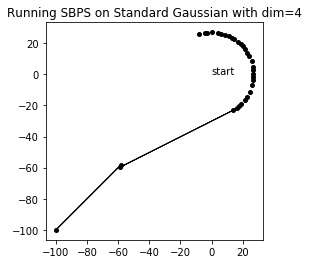

In [59]:
# plotting everything together

gaus_location = np.transpose(x_list)

horizontal = gaus_location[0]
vertical = gaus_location[1]

colors = (0,0,0)
area = (np.pi*10)
num_points = len(horizontal)

# Plot

# plt.imshow(ener_vals_gaus, cmap='YlOrRd', extent=[-3, 3, -3, 3])

# plt.yticks(np.arange(-3, 4, 1))
# plt.xticks(np.arange(-3, 4, 1))
plt.axes().set_aspect('equal')

plt.scatter(horizontal, vertical, s=area/2, c = np.array([[0,0,0]]))    # if this example code is correct, 1st arg is x-axis; 2nd arg is y-axis.
plt.title('Running SBPS on Standard Gaussian with dim=4')

for i in range(0,5):
    plt.arrow(horizontal[i], vertical[i], horizontal[i+1]-horizontal[i], vertical[i+1]-vertical[i], width=0.0001, length_includes_head=True, head_width=0.0001, shape='full')


plt.annotate('start', (0, 0))
    

plt.show()

Observations: it seems to me that both BPS and SBPS will run into this seemingly problematic circular shape of bouncing (if I initialise x0 = (-100,-100) and v0 = (1,1).)--- probably because lambda_ref is set to be small, and exact_gaus_noise_var is also set small, which does not randomising bounce enough. [?]

# Then, try with the Logistic Regression problem with Bernoulli likelihood.

In [88]:

test_input = np.random.normal(0, 5, (100,4))
test_output = np.random.binomial(1, 0.5, 100)

test_dist_logistic_1 = Logistic_Regression_Bern_likelihood(obs_input = test_input, obs_output = test_output, 
                                                           noise_presence = True, subsampling_num = 10, 
                                                           nature_of_noise = 'subsampling')


In [89]:

x_list, v_list, t_list = SBPS(x0 = np.zeros(4), v0 = np.array([1,1,1,1]), Time = 20, lambda_ref = 0.01, 
                              prob_dist = test_dist_logistic_1, delta_t = 0.1, k = 2)


In [100]:
len(x_list)

1123

In [102]:
v_list[1122].dot(v_list[1122])

4.000000000000025

This is very weird: in a time period of 20, 1122 bounces occurs! And note that none of them is "refreshment".

# Try with a more well-constructed logistic regression scenario.

First, we fix a true parameter w in R^20. Then, 1000 independent inputs are generated from multivariate standard Gaussian. For each input x_i in R^20, we sample the output label y_i from Bernoulli(1/(1 + exp(-w.dot(x_i)))).

This construction of dataset is nearly the same as the one in experiment 7.1 of SBPS paper.

In [64]:

w = np.random.randint(-5, 6, 20)
obs_input = np.random.multivariate_normal(np.zeros(20), np.identity(20), 1000)

prob_params = 1/(1 + np.exp(-obs_input.dot(w)))

obs_output = np.random.binomial(1, prob_params)


In [65]:

test_dist_logistic_2 = Logistic_Regression_Bern_likelihood(obs_input = obs_input, obs_output = obs_output, 
                                                           noise_presence = True, subsampling_num = 100, 
                                                           nature_of_noise = 'subsampling')


In [67]:

x_list_2, v_list_2, t_list_2 = SBPS(x0 = np.zeros(20), v0 = 0.5*np.ones(20), Time = 20, lambda_ref = 0.01, 
                              prob_dist = test_dist_logistic_2, delta_t = 0.1, k = 3)


In [68]:
print('length of x_list_2: ', len(x_list_2))
print('length of v_list_2: ', len(v_list_2))
print('length of t_list_2: ', len(t_list_2))

length of x_list_2:  82
length of v_list_2:  82
length of t_list_2:  82


The following command verifies that the magnitude of the velocity vector stays the same after bounces.

The test is passed.